<h1 align="center">Volume 4: River Crossing.</h1>

    Bryant McArthur
    Math 439
    February 2, 2023

In [2]:
import numpy as np
from scipy.integrate import quad
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate as bary
from numpy import linalg as la
from scipy.optimize import root

# Problem 1
Assume that the current is given by $c(x) = −
\frac{7}{10} (x^2 − 1)$. (This function assumes, for example, that the current is faster near the center of the river.) Write a Python
function that accepts as arguments a function $y$, its derivative $y'$, and an $x$-value, and returns $L(x, y(x), y'(x))$ (where $T[y]=\int^1_{-1} L(x,y(x),y'(x))dx$ Use that function to defune a second
function that numerically computes $T[y]$ for a given path $y(x)$.

In [3]:
def first(y, dy, x):
    c = lambda x: -(7/10)*(x**2 - 1)
    alpha = lambda x: (1-c(x)**2)**(-.5)
    return lambda x: alpha(x)*np.sqrt(1+(alpha(x)*dy(x))**2) - (alpha(x)**2*c(x)*dy(x))

def second(y,dy,x_val=0):
    return quad(first(y,dy,x_val), -1, 1)[0]

# Problem 2

Let y(x) be the straight-line path between A = (−1, 0) and B = (1, 5). Numerically calculate T[y] to get an upper bound on the minimum time required to cross from A to
B. Using (18.2), find a lower bound on the minimum time required to cross.

In [4]:
a,b = -1,1
alpha,beta = 0,5
x0 = np.linspace(a,b,100+1)
y = lambda x: (beta - alpha)/(b-a)*(x-a) + alpha
dy = lambda x: 5/2 + 0*x

T = second(y,dy,x0)
print("Upper bound: ", T)

# to take a lower bound assume secant is one
secant = lambda x: 1
print("Lower bound: ", quad(secant, -1, 1)[0])

Upper bound:  3.8770820491384126
Lower bound:  2.0


# Problem 3

Numerically solve the Euler-Lagrange equation (18.4), using c(x) = −
7
10 (x
2 − 1)
and α = (1 − c
2
)
−1/2
, and y(−1) = 0, y(1) = 5.
Hint: Since this boundary value problem is defined over the doimain [−1, 1], it is easy to
solve using the pseudospectral method. Begin by replacing each d
dx with the pseudospectral
differentiation matrix D. Then impose the boundary conditions and solve.

In [5]:
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

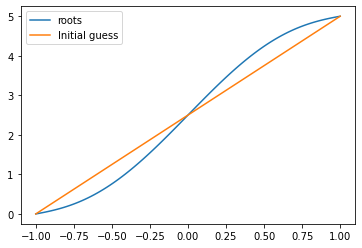

In [6]:
def first(dy, x):
    c = lambda x: -(7/10)*(x**2 - 1)
    alpha = lambda x: (1-c(x)**2)**(-.5)
    return (alpha(x)**3)*dy*(1+(alpha(x)*dy)**2)**(-.5) - alpha(x)**2*c(x)

D,x = cheb(5)
def new_f(y):
    dy = D@y
    
    chunk = first(dy,x)
    big_chunk = D@chunk
    
    # Force Conditions
    big_chunk[0] -=  y[0]-5
    big_chunk[-1] -= y[-1]
    
    
    return big_chunk
    
 
a,b = -1,1
alpha,beta = 0,5
x0 = np.linspace(a,b,6)
y = lambda x: (beta - alpha)/(b-a)*(x-a) + alpha
y0 = y(x0)

roots = root(new_f, y(x0)).x

baryx = np.linspace(-1, 1, 100)
y = bary(x, roots, baryx)

plt.plot(baryx, y, label="roots")
plt.plot(x0, y0, label="Initial guess")
plt.legend()
plt.show()

# Problem 4

Plot the angle at which the boat should be pointed at each $x$-coordinate. (Hint: use Equation 1.1; see Figure 1.3. Note that the angle the boat should be steered is NOT described by the tangent vector to the trjaectory)

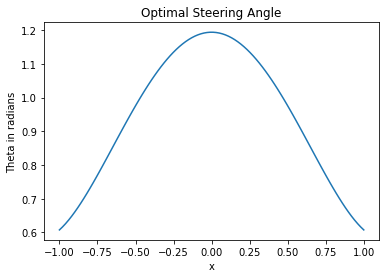

In [16]:
a,b = -1,1
alpha,beta = 0,5
x0 = np.linspace(a,b,100)
c = lambda x: -(7/10)*(x**2 - 1)

dy = D@roots
results = []
for i,xvals in enumerate(x):
    get_theta = lambda theta: c(xvals)*1/np.cos(theta) + np.tan(theta) - dy[i]
    
    results.append(root(get_theta, np.arctan(dy[i])).x)

plt.plot(x0, bary(x,results,x0))
plt.title("Optimal Steering Angle")
plt.ylabel("Theta in radians")
plt.xlabel("x")
plt.show()